### Importing Libraries

In [45]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
#from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

### Load The Dataset

In [46]:
iris_data = load_iris()

X , Y = iris_data.data , iris_data.target
classes = iris_data.target_names
#features_names = iris_data.feature_names

print(classes)
print(X.shape)
print(Y.shape)
print(type(Y))

['setosa' 'versicolor' 'virginica']
(150, 4)
(150,)
<class 'numpy.ndarray'>


### Split the dataset to test & train

In [47]:
x_train , x_test , y_train , y_test = train_test_split(X, Y, train_size= 0.8, shuffle= True, random_state= 45)

In [48]:
for i in range(10):
    print(f'{i+1}. Features: {x_train[i]} , Targeted label: {y_train[i]} , Targeted Class Name: {classes[y_train[i]]}')

1. Features: [6.8 2.8 4.8 1.4] , Targeted label: 1 , Targeted Class Name: versicolor
2. Features: [5.7 2.9 4.2 1.3] , Targeted label: 1 , Targeted Class Name: versicolor
3. Features: [6.  2.2 5.  1.5] , Targeted label: 2 , Targeted Class Name: virginica
4. Features: [5.8 2.7 5.1 1.9] , Targeted label: 2 , Targeted Class Name: virginica
5. Features: [5.  3.  1.6 0.2] , Targeted label: 0 , Targeted Class Name: setosa
6. Features: [6.4 3.1 5.5 1.8] , Targeted label: 2 , Targeted Class Name: virginica
7. Features: [4.3 3.  1.1 0.1] , Targeted label: 0 , Targeted Class Name: setosa
8. Features: [5.  3.4 1.6 0.4] , Targeted label: 0 , Targeted Class Name: setosa
9. Features: [6.4 2.9 4.3 1.3] , Targeted label: 1 , Targeted Class Name: versicolor
10. Features: [4.8 3.1 1.6 0.2] , Targeted label: 0 , Targeted Class Name: setosa


### Softmax

In [49]:
def softmax(y_logits):
    return np.exp(y_logits) / np.sum(np.exp(y_logits), axis=1, keepdims=True, dtype=float)  # Return probabilities

### One Hot Encoding

In [50]:
def one_hot_encode(y):
    no_classes = len(np.unique(y))
    y_encoded = np.zeros((len(y) , no_classes), dtype= int)
    for index, target in enumerate(y):
        y_encoded[index][target] = 1
    return y_encoded

### MultiClass Logistic Regression

In [51]:
def multiclass_logisticRegression(x_train , y_train, learning_rate, epochs):

    # Get the total no. of samples-> N , no. of features and the number of classes in the dataset
    no_samples, no_features = x_train.shape
    no_classes = len(np.unique(y_train))

    # Initialize the weights and biases
    b = np.zeros(shape=(1,no_classes), dtype=float)
    w = np.zeros(shape=(no_features, no_classes), dtype=float)
    y_prob, y_logits = np.zeros(shape=(no_samples, no_classes), dtype=float) , np.zeros(shape=(no_samples, no_classes), dtype=float)


    # Loop to get the minimum loss (Gradient Descent)
    for epoch in range(epochs):
        y_logits = np.dot(x_train, w) + b      # Get the prediction (logits)
        y_prob = softmax(y_logits)      
        y_pred = np.zeros(shape= (no_samples, no_classes), dtype= int) 
        pred_labels = np.argmax(y_prob, axis=1)         # Get the class corresponding to maximum probability
        # Get the predictions from the probabilities previously calculated
        for indx, label in enumerate(pred_labels):
            y_pred[indx][label] = 1
        
        loss = (y_prob - one_hot_encode(y_train))    # Get the loss

        dloss_db = np.sum(loss, axis=0) 
        dloss_dw = np.dot(x_train.T, loss) #/ no_samples

        b -= learning_rate*dloss_db         # Update the biases
        w -= learning_rate*dloss_dw         # Update the weights
        
    return w, b     # Return the weights and biases respectively

### Make predictions

In [52]:
def predict(weights, biases, x):
    Z = np.dot(x, weights) + biases
    A = softmax(Z)
    return classes[np.argmax(A)]    # Return the class with maximum probability

### Get the Confusion Matrix

In [53]:
# Function to get the confusion matrix for each class
def confusion_metrics(x_test, y_test, weights, biases):

    # Get the probabilities for each class
    Z = np.dot(x_test, weights) + biases
    y_probabilities = softmax(Z)
    thresholds = np.linspace(0, 1, 1000)    # Array of Thresholds

    tpr, fpr = np.zeros((len(thresholds),), dtype= float) , np.zeros((len(thresholds),), dtype= float) 

    true_pos, true_neg = np.zeros((len(classes), len(thresholds)), dtype= int) , np.zeros((len(classes), len(thresholds)), dtype= int)
    false_pos, false_neg = np.zeros((len(classes), len(thresholds)), dtype= int) , np.zeros((len(classes), len(thresholds)), dtype= int)

    # Get TP , FP , TN , FN for each class
    for iteration in range(len(classes)):
        indx = 0
        for threshold in thresholds:
            for row, class_data in enumerate(y_probabilities[:][iteration]):
                if(class_data >= threshold):
                    if(y_test[row] == iteration):
                        true_pos[iteration][indx] += 1
                    else:
                        false_pos[iteration][indx] += 1
                elif(class_data < threshold):
                    if(y_test[row] != iteration):
                        true_neg[iteration][indx] += 1
                    else:
                        false_neg[iteration][indx] += 1
            indx +=1

    # We find the True positive rate and False positive rate based on the given threshold
    tpr = np.sum(true_pos, axis= 0) / np.sum((true_pos + false_neg), axis= 0)
    fpr = np.sum(false_pos, axis= 0) / np.sum((true_neg + false_pos), axis= 0)

    return fpr, tpr

### Get the Evaluation Metrics

In [54]:
def evaluation_metrics(true_positive, true_negative, false_positive, false_negative):
    
    recall = (true_positive) / (true_positive + false_negative)
    f1_score = (2 * true_positive) / ((2 * true_positive) + false_positive + false_negative)
    precision = (true_positive) / (true_positive + false_positive)
    specificity = (true_negative) / (true_negative + false_positive)
    informedness = recall + specificity - 1
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

    print(f'Estimated recall: {recall}')
    print(f'Estimated f1_score: {f1_score}')
    print(f'Estimated Precision: {precision}')
    print(f'Estimated Specificity: {specificity}')
    print(f'Estimated Informedness: {informedness}')
    print(f'Estimated Accuracy: {accuracy}')

### Test the Model

In [55]:
def test(weights, biases, x_test, y_test):
    no_classes = len(np.unique(y_test))
    true_positives, true_negatives, false_positives, false_negatives = np.zeros((no_classes)), np.zeros((no_classes)), np.zeros((no_classes)), np.zeros((no_classes))
    for target in range(no_classes):
        true_positives[target] = np.sum([ 1 for x , y in zip(x_test, y_test) if (predict(weights, biases, x) == classes[y]) and  (classes[y] == classes[target]) ])
        false_positives[target] = np.sum([ 1 for x , y in zip(x_test, y_test) if (predict(weights, biases, x) == classes[target]) and  (classes[y] != classes[target]) ])
        true_negatives[target] = np.sum([ 1 for x , y in zip(x_test, y_test) if (predict(weights, biases, x) == classes[y]) and  (classes[y] != classes[target]) ])
        false_negatives[target] = np.sum([ 1 for x , y in zip(x_test, y_test) if (predict(weights, biases, x) != classes[target]) and  (classes[y] == classes[target]) ])
    
    evaluation_metrics(np.sum(true_positives), np.sum(true_negatives), np.sum(false_positives), np.sum(false_negatives))
    #positives = np.sum([ 1 for x , y in zip(x_test, y_test) if predict(weights, biases, x) == classes[y] ])   # No. of positively classified samples
    #negatives = len(x_test) - positives
    #accuracy = positives / len(x_test)

### Plot Function

In [56]:
def plot_roc(fpr, tpr):
    # Use Trapezoidal rule to calculate the area under the curve and approximating the intergral
    auc = np.trapz(fpr,tpr) + 1
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' %(auc))

    # Plot line with slope of 1
    plt.plot([0, 1], [0, 1], 'k-', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.legend(loc="lower right")

    # Add Labels to the Plot
    plt.ylabel('True Positive Rate (sensitivity)')
    plt.xlabel('False Positive Rate (1-specificity)')
    plt.title('Receiver Operating Characteristic for multi-class')

    plt.show()

### Train , Test & Visualize

In [57]:
weights, biases = multiclass_logisticRegression(x_train, y_train, 0.0001, 400)  #1000
#print(f'Weights: {weights}' , '\n\n' , f'Biases: {biases}', '\n')
#print('Predicted Class for input X = [0.002, 0.4, 0.0234, 0.2] :', predict(weights, biases, np.array([0.002, 0.4, 0.0234, 0.2])))


In [58]:
test(weights, biases, x_test, y_test)

Estimated recall: 0.9666666666666667
Estimated f1_score: 0.9666666666666667
Estimated Precision: 0.9666666666666667
Estimated Specificity: 0.9830508474576272
Estimated Informedness: 0.949717514124294
Estimated Accuracy: 0.9775280898876404


In [59]:
fpr, tpr = confusion_metrics(x_test, y_test, weights, biases)   # Get the Confusion Matrix

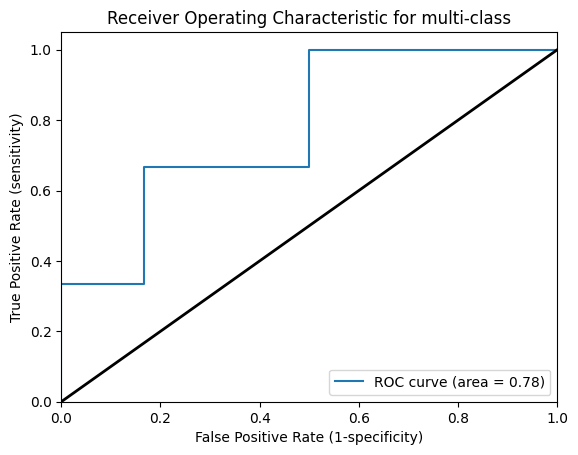

In [60]:
plot_roc(fpr, tpr)   # Plot the ROC Curve